In [2]:
#import libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import os
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
import warnings 
import datetime
%matplotlib inline
#ignore all warnings
warnings. filterwarnings("ignore") 

# 1 - Data Gathering

#### 1.2 - Programmatic Download

## 1.1 - Handed File

In [3]:
#Given file
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")
#test
twitter_archive

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

## 1.2 - Programmatic Download

In [4]:
#Downloading The tweet image predictions TSV file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
file_name = url.split("/")[-1]
response = requests.get(url)
with open(file_name, mode="wb") as file:
    file.write(response.content)

In [5]:
#Reading image predictions
image_predictions = pd.read_csv(file_name, sep='\t')
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


## 1.3 - Query Twitter's API 

In [6]:
#Create an API object to gather Twitter data
consumer_key = "VKoLYspK4OpjFsqp6WLR6jrAC"
consumer_secret = "vrum2WRhOptHC5uaRj7n34DwCRiiCuakzNToqRgjcynEz8cYho"
access_token = "2918350510-1IrjvTJdhAuQGizPGJ0B3fIlXQYeIpVdDjUDoWP"
access_secret = "7PZS2sAAcgwdgvLczKArlPU1yVe3qlEIC8gW7seE4mI5z"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
#wait_on_rate_limit=True to account for the twitter rate limit
api = tweepy.API(auth, wait_on_rate_limit=True)

In [7]:
#Getting data through the api
#making a failed list
fail_list = []
tweet_id = list(twitter_archive["tweet_id"])
#save tweets's JSON in a .txt file
with open("tweet_json.txt", mode="w") as file :
    for id in tweet_id:
        try:
            tweet_data = api.get_status(id, tweet_mode="extended")
            #._json reference : https://github.com/tweepy/tweepy/issues/1102
            json.dump(tweet_data._json, file)
            file.write("\n")
        except tweepy.TweepError:
            fail_list.append(id)
no_fail = len(fail_list)
print("{} tweets have failed".format(no_fail))

28 tweets have failed


In [4]:
#Turn file to DataFrame 
tweets_df = pd.read_json("tweet_json.txt", lines=True)

In [9]:
#Test
tweets_df

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2326,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


# 2 - Data Assessing 

## 1.1 - Visual

In [10]:
#Get an overview of the data
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [11]:
#Get an overview of the data
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [12]:
#Get an overview of the data
tweets_df

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2326,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


## 1.2 - Programmatic  

In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
#check for duplicates
len(twitter_archive.tweet_id.unique())

2356

In [15]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [6]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
17,888804989199671297,NaN,NaN,2017-07-22 16:56:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeke. He has a new stick. Very proud o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/888804989...,13,10,Zeke,None,None,None,None
1085,738184450748633089,NaN,NaN,2016-06-02 01:44:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For the last time, we only rate dogs. Pls stop...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/738184450...,9,10,None,None,None,None,None
436,820314633777061888,NaN,NaN,2017-01-14 17:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We are proud to support @LoveYourMelon on thei...,NaN,NaN,NaN,"https://www.loveyourmelon.com/pages/ourstory,h...",14,10,None,None,None,None,None
390,826240494070030336,NaN,NaN,2017-01-31 01:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in any mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826240494...,11,10,None,None,None,None,None
353,831309418084069378,NaN,NaN,2017-02-14 01:09:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scooter and his son Montoya. Scooter ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831309418...,12,10,Scooter,None,None,None,None


In [17]:
twitter_archive["rating_numerator"].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [18]:
twitter_archive["rating_denominator"].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
twitter_archive[twitter_archive["rating_denominator"] < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [20]:
twitter_archive.text[2335]

'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv'

In [21]:
twitter_archive[twitter_archive["rating_denominator"] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


In [22]:
twitter_archive.text[1068]

'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ'

In [72]:
#show whole text 
pd.set_option("display.max_colwidth", None)
with pd.option_context('display.max_rows', None):
    display(twitter_archive["text"])

0                                                                   This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1              This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2                               This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                                         This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4              This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
5              Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breat

In [24]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [26]:
image_predictions[image_predictions.jpg_url.duplicated() == True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [27]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2328 non-null   datetime64[ns, UTC]
 1   id                             2328 non-null   int64              
 2   id_str                         2328 non-null   int64              
 3   full_text                      2328 non-null   object             
 4   truncated                      2328 non-null   bool               
 5   display_text_range             2328 non-null   object             
 6   entities                       2328 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2328 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [28]:
tweets_df.lang.value_counts()

en     2310
und    7   
nl     3   
in     3   
tl     1   
ro     1   
eu     1   
es     1   
et     1   
Name: lang, dtype: int64

## 1.3 - Quality Issues
<ol>
<li> Some tweets are retweets in all tables.</li>
<li>some tweets are replies in all tables.</li>
<li>some tweets don't have images in twitter_archive.</li>
<li>remove duplicates in jpg_url.</li>
<li>id column name in tweets_df is inconsistent with other tables.</li> 
<li>tweet_id in three tables is int not str.</li>
<li>twitter_archive timestamp has wrong data type and datatype.</li>
<li>twitter_archive timestamp should be two different columns.</li>
<li>rating_denominator and rating_numerator has wrong values.</li>
<li>rating_numerator column has float values that are int.</li>
<li>rating_denominator is not useful because have known value.</li>
<li>change None to NaN in name column.</li>
<li>change to nan values in dog_type new column.</li>
<li>("_") seperate dog names.</li>
    <li>dog names in image_prediction upper and lower inconsistency.</li>
</ol>

## 1.4 - tidiness issues
- All three should be one DataFrame
   ### 1 - twitter_archive
      - Doggo, Floofer, Pupper, Puppo should be one column 
      - unnecessary columns 
 ### 2 - image_prediction 
      - non descriptive columns names
      - all can be one column
 ### 3 - tweets_df
      - unnecessary columns

# 3 - Data Cleaning 

In [7]:
#copy of DataFrames
twitter_archive_copy = twitter_archive.copy()
image_predictions_copy = image_predictions.copy() 
tweets_df_copy = tweets_df.copy()

### Define

1-remove replies from twitter_archive to guide the process

### Code 

In [8]:
#remove replies from twitter_archive
twitter_archive_copy.drop(twitter_archive_copy[twitter_archive_copy.retweeted_status_id.notna()].index, inplace=True)

### Test 

In [9]:
#test
twitter_archive_copy[twitter_archive_copy.retweeted_status_user_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Define 
2-remove retweets from twitter_archive to guide the process

### Code 

In [10]:
#remove retweets from twitter_archive
twitter_archive_copy.drop(twitter_archive_copy[twitter_archive_copy.in_reply_to_status_id.notna()].index, inplace=True)

### Test 

In [11]:
#test
twitter_archive_copy[twitter_archive_copy.in_reply_to_user_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Define

3 - remove tweet_ids without images in twitter_archive

### Code 

In [12]:
#make Tweet ids list to remove tweet_ids in twitter_archive without images 
image_ids = list(image_predictions_copy.tweet_id.unique())
#remove non image ids
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.tweet_id.isin(image_ids)]

### Test


In [13]:
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1971 non-null   object 
 4   source                      1971 non-null   object 
 5   text                        1971 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1971 non-null   object 
 10  rating_numerator            1971 non-null   int64  
 11  rating_denominator          1971 non-null   int64  
 12  name                        1971 non-null   object 
 13  doggo                       1971 

### Define
Use twitter_archive_copy to guide the process to clean image_predictions_copy

### Code 

In [14]:
#remove replies and retweets from image_predictions_copy by the same process
archive_ids = list(twitter_archive_copy.tweet_id.unique())
#removal inplace
image_predictions_copy = image_predictions_copy[image_predictions_copy.tweet_id.isin(archive_ids)]

### Test 

In [15]:
#test 
len(image_predictions_copy.tweet_id) == len(twitter_archive_copy.tweet_id)

True

### Define
Use twitter_archive_copy to guide the process to clean tweets_df_copy

### Code 

In [16]:
#remove replies and retweets from tweets_df_copy by the same process
tweets_df_copy = tweets_df_copy[tweets_df_copy.id.isin(archive_ids)]

### Test 

In [17]:
tweets_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     1961 non-null   datetime64[ns, UTC]
 1   id                             1961 non-null   int64              
 2   id_str                         1961 non-null   int64              
 3   full_text                      1961 non-null   object             
 4   truncated                      1961 non-null   bool               
 5   display_text_range             1961 non-null   object             
 6   entities                       1961 non-null   object             
 7   extended_entities              1961 non-null   object             
 8   source                         1961 non-null   object             
 9   in_reply_to_status_id          0 non-null      float64            
 10  in_reply_to_status_id_st

### Define
remove unnecessary columns in twitter_archive_copy

### Code 

In [18]:
#remove unneeded columns in twitter_archive_copy
twitter_archive_copy.drop(twitter_archive_copy.loc[:, "in_reply_to_status_id":"in_reply_to_user_id"].columns, axis=1, inplace=True)
twitter_archive_copy.drop(twitter_archive_copy.loc[:, "retweeted_status_id":"expanded_urls"].columns, axis=1, inplace=True)

### Test 

In [19]:
#test
twitter_archive_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Define
remove unnecessary columns in tweets_df_copy

### Code 

In [20]:
#remove unneeded columns in tweets_df_copy
tweets_df_copy.drop(tweets_df_copy.loc[:, "id_str":"is_quote_status"].columns, axis = 1, inplace=True) 
tweets_df_copy.drop(tweets_df_copy.loc[:, "favorited":"possibly_sensitive_appealable"].columns, axis = 1, inplace=True) 
tweets_df_copy.drop(tweets_df_copy.loc[:, "retweeted_status":"quoted_status"].columns, axis = 1, inplace=True)
tweets_df_copy.drop("created_at", axis = 1, inplace=True) 

### Test 

In [21]:
#test
tweets_df_copy.columns

Index(['id', 'retweet_count', 'favorite_count', 'lang'], dtype='object')

### Define
remove duplicates in jpg_url column

### Code 

In [22]:
#remove jpg_url duplicates
image_predictions_copy.drop_duplicates(subset=["jpg_url"], keep="last", inplace= True)

### Test 

In [23]:
#test
image_predictions_copy[image_predictions_copy.jpg_url.duplicated() == True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Define
consistency of names between tables

### Code 

In [24]:
#change id in tweet_id to be consistent
tweets_df_copy.rename(columns = {"id":"tweet_id"}, inplace = True)

### Test 

In [25]:
#test
tweets_df_copy.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'lang'], dtype='object')

### Define 
can't preform certain analysis if it's int 

### Code 

In [26]:
#change tweet_id data type in the three for consistency
twitter_archive_copy.tweet_id = twitter_archive_copy.tweet_id.astype(str)
image_predictions_copy.tweet_id = image_predictions_copy.tweet_id.astype(str)
tweets_df_copy.tweet_id = tweets_df_copy.tweet_id.astype(str)

### Test 

In [27]:
#test
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   object
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   rating_numerator    1971 non-null   int64 
 5   rating_denominator  1971 non-null   int64 
 6   name                1971 non-null   object
 7   doggo               1971 non-null   object
 8   floofer             1971 non-null   object
 9   pupper              1971 non-null   object
 10  puppo               1971 non-null   object
dtypes: int64(2), object(9)
memory usage: 184.8+ KB


### Define
change timestamp datatype to datetime and split it into two columns

### Code 

In [28]:
#change timestamp to datetime
twitter_archive_copy["timestamp"] = pd.to_datetime(twitter_archive_copy["timestamp"])
#split timestamp into two columns
twitter_archive_copy["date"] = twitter_archive_copy["timestamp"].apply(lambda date: date.strftime('%Y-%d-%m'))
twitter_archive_copy["time"] = twitter_archive_copy["timestamp"].apply(lambda time: time.strftime('%H:%M:%S'))
twitter_archive_copy.drop(["timestamp"], axis=1, inplace= True)


### Test 

In [29]:
#test
pd.set_option("display.max_colwidth", None)
twitter_archive_copy

,tweet_id,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None,2017-01-08,16:23:56
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,None,None,None,2017-01-08,00:17:27
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None,2017-31-07,00:18:03
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None,2017-30-07,15:58:51
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,None,None,None,None,2017-29-07,16:00:24
...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,5,10,None,None,None,None,None,2015-16-11,00:24:50
2352,666044226329800704,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,6,10,a,None,None,None,None,2015-16-11,00:04:52
2353,666033412701032449,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,9,10,a,None,None,None,None,2015-15-11,23:21:54
2354,666029285002620928,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,7,10,a,None,None,None,None,2015-15-11,23:05:30


### Define

To get the rating from the text i will first extract and then remove the url from the text column then i am going to use re library to find the rate in the text but first i need to narrow down the list of ids to look for.

### Code 

In [30]:
#extracting url from text
twitter_archive_copy["tweet_url"] = twitter_archive_copy["text"].str.extract('(https://t.co/[A-z0-9_]+)')
#remove the url from text column
twitter_archive_copy["text"] = twitter_archive_copy["text"].str.replace("(https://t.co/[A-z0-9_]+)", "")

In [31]:
#get a list of text with more than one rating 
index_no = twitter_archive_copy[twitter_archive_copy.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].index
print(index_no)

Int64Index([ 766, 1007, 1068, 1165, 1202, 1222, 1359, 1459, 1465, 1508, 1525,
            1538, 1662, 1795, 1832, 1897, 1901, 1970, 2010, 2064, 2113, 2177,
            2216, 2263, 2272, 2306, 2335],
           dtype='int64')


In [32]:
#after further assessing most of them are right 
not_right = [766, 1068, 1165, 1202, 1662, 2335 ]

In [33]:
twitter_archive_copy

,tweet_id,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time,url
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,Phineas,None,None,None,None,2017-01-08,16:23:56,https://t.co/MgUWQ76dJU
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,Tilly,None,None,None,None,2017-01-08,00:17:27,https://t.co/0Xxu71qeIV
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12,10,Archie,None,None,None,None,2017-31-07,00:18:03,https://t.co/wUnZnhtVJB
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13,10,Darla,None,None,None,None,2017-30-07,15:58:51,https://t.co/tD36da7qLQ
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12,10,Franklin,None,None,None,None,2017-29-07,16:00:24,https://t.co/AtUZn91f7f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10,5,10,None,None,None,None,None,2015-16-11,00:24:50,https://t.co/4B7cOc1EDq
2352,666044226329800704,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10,6,10,a,None,None,None,None,2015-16-11,00:04:52,https://t.co/DWnyCjf2mx
2353,666033412701032449,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af,9,10,a,None,None,None,None,2015-15-11,23:21:54,https://t.co/y671yMhoiR
2354,666029285002620928,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of,7,10,a,None,None,None,None,2015-15-11,23:05:30,https://t.co/r7mOb2m0UI


In [34]:
#import 
import re
#for loop to iterate throught each 
for i in not_right :
    twitter_archive_copy.rating_numerator[i] = re.findall(r"\s\d+\/\d+", twitter_archive_copy.text[i])[1].split("/")[0]

### Test 

In [35]:
twitter_archive_copy[twitter_archive_copy.index.isin(not_right)]

,tweet_id,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time,url
766,777684233540206592,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",11,10,None,None,None,None,None,2016-19-09,01:42:24,https://t.co/SuXcI9B7pQ
1068,740373189193256964,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",14,11,None,None,None,None,None,2016-08-06,02:41:38,https://t.co/XAVDNDaVgQ
1165,722974582966214656,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all,13,20,None,None,None,None,None,2016-21-04,02:25:47,https://t.co/eV1diwds8a
1202,716439118184652801,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,11,50,Bluebert,None,None,None,None,2016-03-04,01:36:11,https://t.co/Kky1DPG4iq
1662,682962037429899265,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,10,11,Darrel,None,None,None,None,2016-01-01,16:30:13,https://t.co/7EsP8LmSp5
2335,666287406224695296,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,9,2,an,None,None,None,None,2015-16-11,16:11:11,https://t.co/d9NcXFKwLv


### Define

some numerator need to be change to float 

### Code 

In [36]:
twitter_archive_copy.rating_numerator = twitter_archive_copy.rating_numerator.astype(float)
twitter_archive_copy.rating_denominator = twitter_archive_copy.rating_denominator.astype(float)

### Test 

In [37]:
#test
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   object 
 1   source              1971 non-null   object 
 2   text                1971 non-null   object 
 3   rating_numerator    1971 non-null   float64
 4   rating_denominator  1971 non-null   float64
 5   name                1971 non-null   object 
 6   doggo               1971 non-null   object 
 7   floofer             1971 non-null   object 
 8   pupper              1971 non-null   object 
 9   puppo               1971 non-null   object 
 10  date                1971 non-null   object 
 11  time                1971 non-null   object 
 12  url                 1971 non-null   object 
dtypes: float64(2), object(11)
memory usage: 295.6+ KB


### Define
missing float rating_numerator values 

### Code 

In [38]:
float_num = list(twitter_archive_copy.tweet_id[twitter_archive_copy.text.str.contains( r"\s\d+[.]\d+\/\d+")].index)
print(float_num)

[45, 695, 763, 1712]


In [39]:
for i in float_num :
    twitter_archive_copy.rating_numerator[i] = float(re.findall(r"\s\d+[.]\d+\/\d+", twitter_archive_copy.text[i])[0].split("/")[0])

### Test 

In [40]:
twitter_archive_copy.rating_numerator[45]

13.5

### Define 
remove not rating tweets 

### Code 

In [41]:
twitter_archive_copy.rating_numerator.value_counts(ascending=True)

420.00       1
80.00        1
204.00       1
121.00       1
44.00        1
144.00       1
88.00        1
45.00        1
24.00        1
9.75         1
0.00         1
11.26        1
165.00       1
11.27        1
13.50        1
1776.00      1
99.00        1
84.00        1
60.00        1
1.00         4
2.00         9
4.00        15
3.00        19
5.00        32
6.00        32
14.00       34
7.00        51
8.00        95
9.00       150
13.00      254
11.00      394
10.00      418
12.00      445
Name: rating_numerator, dtype: int64

In [42]:
lis_of_high_rating = twitter_archive_copy[twitter_archive_copy.rating_numerator >= 24].index.tolist()
print(lis_of_high_rating)

[433, 516, 902, 979, 1120, 1228, 1254, 1274, 1351, 1433, 1635, 1779, 1843, 2074]


In [43]:
twitter_archive_copy.text[433]

'The floofs have been released I repeat the floofs have been released. 84/70 '

In [44]:
#not rating 
twitter_archive_copy.text[516]

'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n '

In [45]:
img = twitter_archive_copy.tweet_id[2074]
#snopp dog image not that close
image_predictions_copy.jpg_url[image_predictions_copy.tweet_id == img]

277    https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg
Name: jpg_url, dtype: object

In [46]:
#droping index form dataframe and list
twitter_archive_copy.drop([516, 2074], inplace=True)
del lis_of_high_rating[1]
del lis_of_high_rating[-1]

In [47]:
for i in lis_of_high_rating:
    deno_no = twitter_archive_copy.rating_denominator[i]
    num_no = twitter_archive_copy.rating_numerator[i]
    divider = deno_no / 10
    num_no = num_no / divider
    twitter_archive_copy.rating_numerator[i] = num_no

### Test

In [48]:
twitter_archive_copy.rating_numerator.value_counts()

12.00      449
10.00      419
11.00      399
13.00      254
9.00       151
8.00        95
7.00        51
14.00       34
6.00        32
5.00        32
3.00        19
4.00        15
2.00         9
1.00         4
11.27        1
9.75         1
0.00         1
13.50        1
11.26        1
1776.00      1
Name: rating_numerator, dtype: int64

### Define
Drop rating_denomerator known value.

### Code 

In [49]:
twitter_archive_copy.drop("rating_denominator", inplace=True, axis=1)


### Test

In [50]:
twitter_archive_copy.columns

Index(['tweet_id', 'source', 'text', 'rating_numerator', 'name', 'doggo',
       'floofer', 'pupper', 'puppo', 'date', 'time', 'url'],
      dtype='object')

### Define 
change None to nan in name column

### Code 

In [51]:
twitter_archive_copy.name.replace(to_replace="None", value=np.nan, inplace=True)

### Test 

In [52]:
twitter_archive_copy[twitter_archive_copy.name == "None"]

,tweet_id,source,text,rating_numerator,name,doggo,floofer,pupper,puppo,date,time,url


### Define 
merge doggo , floofer , pupper , puppo to one column named dog_type

### Code 

In [59]:
#change None to "" to make it easy 
name_list = ["doggo", "floofer", "pupper", "puppo"]
for i in name_list:
    twitter_archive_copy[i].replace("None", "", inplace=True)

In [68]:
#use cat to combine
twitter_archive_copy["dog_stage"] = twitter_archive_copy.doggo.str.cat(twitter_archive_copy.floofer).str.cat(twitter_archive_copy.pupper).str.cat(twitter_archive_copy.puppo)
#drop old columns
twitter_archive_copy.drop(name_list, axis=1, inplace=True)
#clean wrong values
twitter_archive_copy["dog_stage"].replace("doggopuppo", "doggo-puppo", inplace = True)
twitter_archive_copy["dog_stage"].replace("doggopupper", "doggo-pupper", inplace = True)
twitter_archive_copy["dog_stage"].replace("doggopuppo", "doggo-ploofer", inplace = True)
twitter_archive_copy["dog_stage"].replace("", np.nan, inplace = True)

### Test 

In [69]:
twitter_archive_copy["dog_stage"].value_counts()

pupper          201
doggo            63
puppo            22
doggo-pupper      8
floofer           7
doggo-puppo       1
doggofloofer      1
Name: dog_stage, dtype: int64

In [70]:
twitter_archive_copy.columns

Index(['tweet_id', 'source', 'text', 'rating_numerator', 'name', 'date',
       'time', 'url', 'dog_stage'],
      dtype='object')

### Define 
Rename none descriptive column names

### Code 

In [89]:
#twitter_archive
twitter_archive_copy.rename(columns={"text": "tweet_text", "name": "dog_name", "url": "tweet_url"}, inplace=True)
#image_predictions
image_predictions_copy.rename(columns={"p1": "first_prediction", "p1_conf": "first_confidence", "p1_dog": "is_dog",
                                  "p2": "second_prediction", "p2_conf": "second_confidence", "p2_dog": "is_dog",
                                  "p3": "third_prediction", "p3_conf": "third_confidence", "p3_dog": "is_dog"}, inplace = True)
tweets_df_copy.rename(columns={"lang": "text_language"}, inplace=True)

### Test 

In [87]:
twitter_archive_copy.columns

Index(['tweet_id', 'date', 'time', 'source', 'tweet_text', 'tweet_url',
       'rating_numerator', 'dog_name', 'dog_stage'],
      dtype='object')

In [93]:
image_predictions_copy.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'first_prediction',
       'first_confidence', 'is_dog', 'second_prediction', 'second_confidence',
       'is_dog', 'third_prediction', 'third_confidence', 'is_dog'],
      dtype='object')

In [80]:
tweets_df_copy.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'text_language'], dtype='object')

### Define
rearrange twitter_archive_copy columns

### Code 

In [83]:
twitter_archive_copy = twitter_archive_copy[["tweet_id", "date", "time", "source", "tweet_text", "tweet_url", "rating_numerator","dog_name", "dog_stage"]]

### Test 

In [84]:
twitter_archive_copy.columns.values

array(['tweet_id', 'date', 'time', 'source', 'tweet_text', 'url',
       'rating_numerator', 'dog_name', 'dog_stage'], dtype=object)

### Define 
inconsistency capitalization issues 

### Code


In [101]:
#change"_" to " "
image_predictions_copy["first_prediction"] = image_predictions_copy.first_prediction.str.replace("_", " ")
image_predictions_copy["second_prediction"] = image_predictions_copy.second_prediction.str.replace("_", " ")
image_predictions_copy["third_prediction"] = image_predictions_copy.third_prediction.str.replace("_", " ")

#capitalize breed
image_predictions_copy["first_prediction"] = image_predictions_copy.first_prediction.str.capitalize()
image_predictions_copy["second_prediction"] = image_predictions_copy.second_prediction.str.capitalize()
image_predictions_copy["third_prediction"] = image_predictions_copy.third_prediction.str.capitalize()


###  Test

In [102]:
image_predictions_copy

,tweet_id,jpg_url,img_num,first_prediction,first_confidence,is_dog,second_prediction,second_confidence,is_dog,third_prediction,third_confidence,is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,Collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,Redbone,0.360687,True,Miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper towel,0.170278,False,Labrador retriever,0.168086,True,Spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


### Define
Merging the dataframes together

### Code 

In [ ]:
#merging
Twitter_archive_master = pd.merge(pd.merge(twitter_archive_copy, tweets_df_copy, on="tweet_id"), image_predictions_copy, on="tweet_id")

### Test 

In [198]:
Twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 0 to 1958
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           1959 non-null   object 
 1   date               1959 non-null   object 
 2   time               1959 non-null   object 
 3   source             1959 non-null   object 
 4   tweet_text         1959 non-null   object 
 5   tweet_url          1959 non-null   object 
 6   rating_numerator   1959 non-null   float64
 7   dog_name           1437 non-null   object 
 8   dog_stage          302 non-null    object 
 9   retweet_count      1959 non-null   int64  
 10  favorite_count     1959 non-null   int64  
 11  text_language      1959 non-null   object 
 12  jpg_url            1959 non-null   object 
 13  img_num            1959 non-null   int64  
 14  first_prediction   1959 non-null   object 
 15  first_confidence   1959 non-null   float64
 16  is_dog             1959 

# 4 - Data Storing

In [206]:
#storing the master Dataframe as csv
Twitter_archive_master.to_csv("twitter_archive_master.csv", index=False)

# 5 - Data Visualization and Analysis 

In [207]:
#import file as new dataframe
twitter_archive_master_df = pd.read_csv("twitter_archive_master.csv")

In [208]:
twitter_archive_master_df.describe()

,tweet_id,rating_numerator,retweet_count,favorite_count,img_num,first_confidence,second_confidence,third_confidence
count,1.959000e+03,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1.959000e+03,1.959000e+03
mean,7.357949e+17,11.442460,2384.038795,8091.262889,1.202654,0.594130,1.347732e-01,6.028526e-02
std,6.747589e+16,39.946641,4265.912079,11915.387230,0.560236,0.271931,1.010010e-01,5.099784e-02
min,6.660209e+17,0.000000,11.000000,69.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.758342e+17,10.000000,530.500000,1723.000000,1.000000,0.362880,5.370120e-02,1.614795e-02
50%,7.087111e+17,11.000000,1156.000000,3636.000000,1.000000,0.587372,1.175080e-01,4.947150e-02
75%,7.877641e+17,12.000000,2717.500000,10055.500000,1.000000,0.846807,1.957615e-01,9.164355e-02
max,8.924206e+17,1776.000000,74965.000000,151531.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [214]:
twitter_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           1959 non-null   int64  
 1   date               1959 non-null   object 
 2   time               1959 non-null   object 
 3   source             1959 non-null   object 
 4   tweet_text         1959 non-null   object 
 5   tweet_url          1959 non-null   object 
 6   rating_numerator   1959 non-null   float64
 7   dog_name           1437 non-null   object 
 8   dog_stage          302 non-null    object 
 9   retweet_count      1959 non-null   int64  
 10  favorite_count     1959 non-null   int64  
 11  text_language      1959 non-null   object 
 12  jpg_url            1959 non-null   object 
 13  img_num            1959 non-null   int64  
 14  first_prediction   1959 non-null   object 
 15  first_confidence   1959 non-null   float64
 16  is_dog             1959 

## 1 - Most common dog breeds?


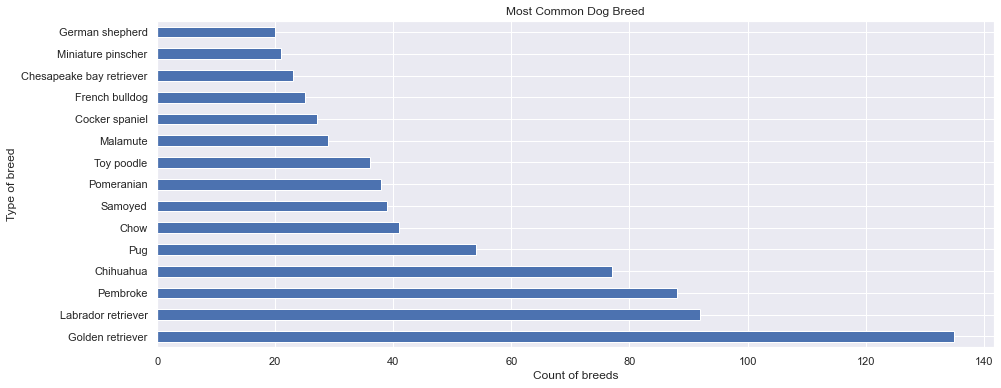

In [187]:
comm_dog_breed = twitter_archive_master_df[twitter_archive_master_df.is_dog].first_prediction.value_counts()[:15]
comm_dog_breed.plot(kind='barh', figsize=(15,6), grid=True)
plt.title("Most Common Dog Breed")
plt.xlabel("Count of breeds")
plt.ylabel("Type of breed");

As you can see Golden Retriever is the Most Common

## 2 - Most common dogs names ?


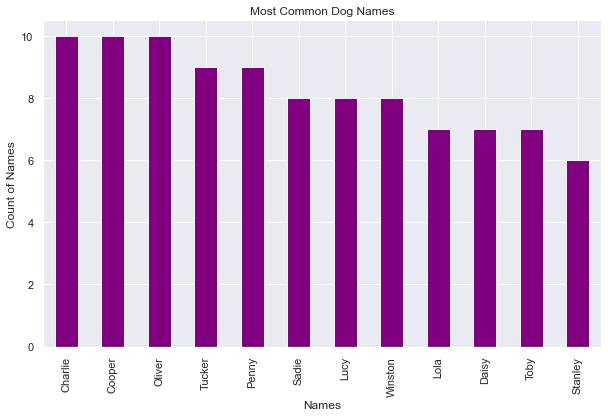

In [188]:
comm_dog_name = twitter_archive_master_df.dog_name.value_counts()[1:14]
comm_dog_name = comm_dog_name.drop(labels=["the"])
comm_dog_name.plot(kind='bar', figsize=(10,6), color="purple", grid=True)
plt.title("Most Common Dog Names")
plt.ylabel("Count of Names")
plt.xlabel("Names");

The Most Common Dogs Names is Charlie , Cooper and Oliver.

## 3 - Most common dog stage ?


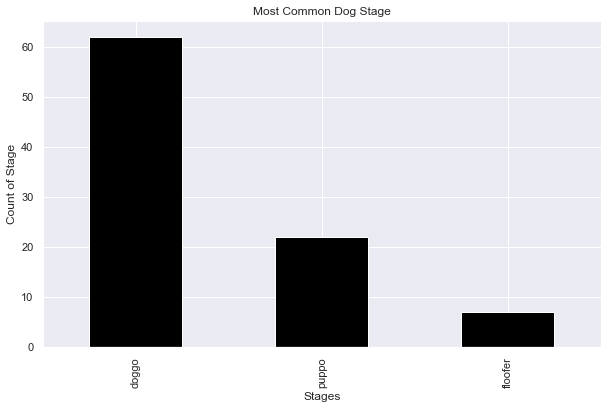

In [186]:
comm_dog_stage = twitter_archive_master_df.dog_stage.value_counts()[1:14]
comm_dog_stage = comm_dog_stage.drop(labels=["doggo-pupper", "doggo-puppo", "doggofloofer"])
comm_dog_stage.plot(kind='bar', figsize=(10,6), color="black", grid=True)
plt.title("Most Common Dog Stage")
plt.ylabel("Count of Stage")
plt.xlabel("Stages");

The Most Common Stage is Doggo.

## 5 - What is the correlation between  number of retweets and likes? 


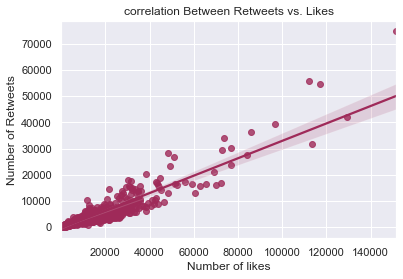

In [193]:
#twitter_archive_master_df.plot.scatter(x="favorite_count",y="retweet_count", color="green")
sns.regplot(x="favorite_count",y="retweet_count", data=twitter_archive_master_df, fit_reg=True, color="#9f2a59") 
plt.title("correlation Between Retweets vs. Likes")
plt.xlabel("Number of likes")
plt.ylabel("Number of Retweets");

Positively correlated.

## 6 -  visualize the number of retweets and likes change overtime

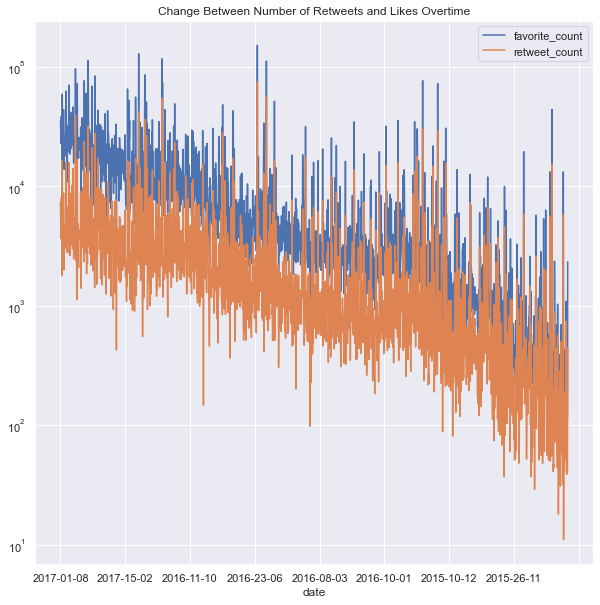

In [196]:
twitter_archive_master_df.plot(x="date", y=["favorite_count", "retweet_count"], figsize=(10,10), logy=True)
plt.title("Change Between Number of Retweets and Likes Overtime");